In [1]:
# limit the thread used by numpy for better parallelization
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import *
from Triangle.Interferometer import *
from Triangle.TDI import *
from Triangle.Glitch import *
from Triangle.GW import *
from Triangle.Cosmology import LuminosityDistance, z_dl

from Triangle_BBH.Utils import ParamArr2ParamDict, ParamDict2ParamArr

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("fork")
print("number of cpus =", multiprocessing.cpu_count())
# pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy
no BBHx waveform
number of cpus = 12


## Load data 

In [3]:
h5filename = "/Users/taijidatacenter/workspace/TDCII_Data/2_2_MBHB_PhenomT_TDIXYZ.h5"
with h5py.File(h5filename, "r") as h5file:
    data_dict = read_dict_from_h5(h5file["/"])
data_dict.keys()

dict_keys(['XYZ', 'time'])

In [4]:
h5filename = "/Users/taijidatacenter/workspace/TDCII_Data/MBHB_PhenomT_parameters.h5"
with h5py.File(h5filename, "r") as h5file:
    param_dict = read_dict_from_h5(h5file["/"])
param_dict.keys()

dict_keys(['chirp_mass', 'coalescence_phase', 'coalescence_time', 'inclination', 'latitude', 'longitude', 'luminosity_distance', 'mass_ratio', 'psi', 'spin_1z', 'spin_2z'])

In [5]:
param_dict["coalescence_time"]

array([330.58527006,  73.49530626, 168.86414951,  14.52710675,
       263.12286916, 262.20426673, 218.27529303, 150.01865017,
       182.99311027,  82.98448095, 167.29296122, 180.01226846,
       273.56257371,  98.10365109, 328.17478035, 107.611646  ,
        35.84100334, 312.72149569, 353.72683702, 151.73862225,
       292.72462148,  94.09561112, 241.3897833 , 111.91042885,
       274.51400134, 239.17347726, 324.8454229 ,  22.98448537,
        88.54396279, 214.63716367, 142.89093574, 133.94643428,
       334.41206412, 235.34272096, 330.55065225,  66.81444399,
       258.27556376, 346.84910377, 161.91418656, 298.96960319,
       294.09184798, 350.35219838,  49.85508333, 341.41560924,
       196.50223474, 322.51966869, 341.26243426, 312.22752188,
       181.16372312, 269.2805559 ])

## Search settings 

In [6]:
t_start = 349.5 * DAY 
Tobs = 1 * DAY 
t_end = t_start + Tobs 

time_idx = np.where((data_dict["time"] >= t_start)&(data_dict["time"] <= t_end))[0]
data_time = data_dict["time"][time_idx]
dt = data_time[1] - data_time[0]
channel_names = list(data_dict["XYZ"].keys())
data_channels_td = np.array([data_dict["XYZ"][ch][time_idx] for ch in channel_names])
print(data_time.shape, data_channels_td.shape)

data_channels_fd = []
FT_args = dict(fsample=1./dt, window_type="tukey", window_args_dict=dict(alpha=0.05))
for i in range(3):
    ff, xf = FFT_window(data_channels_td[i], **FT_args)
    data_channels_fd.append(xf)
data_frequency = ff.copy()
data_channels_fd = np.array(data_channels_fd)

mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 41):
    mask_idx = np.where(np.abs(data_frequency - i*0.025)<i*3e-4)[0]
    mask[mask_idx] = False 
data_frequency = data_frequency[mask]
data_channels_fd = data_channels_fd[:, mask]
print(data_frequency.shape, data_channels_fd.shape)

a_tmp, e_tmp, t_tmp = AETfromXYZ(X=data_channels_fd[0], Y=data_channels_fd[1], Z=data_channels_fd[2])
data_channels_opt_fd = np.array([a_tmp, e_tmp, t_tmp])
channel_names_opt = ["A2", "E2", "T2"]

orbit = Orbit(OrbitDir="../OrbitData/MicroSateOrbitEclipticTCB")
PSDfunc = TDIPSDs()
arms = dict()
for key in MOSA_labels: 
    arms[key] = orbit.LTTfunctions()[key]((t_end+t_start)/2.)
arms = MOSADict(arms)
data_psd_opt = np.array([
    PSDfunc.PSD_A2_unequal(data_frequency, arms), 
    PSDfunc.PSD_E2_unequal(data_frequency, arms), 
    PSDfunc.PSD_T2_unequal(data_frequency, arms), 
])

(17281,) (3, 17281)
(8224,) (3, 8224)


## Signal generator 

In [7]:
source_idx = np.where((param_dict["coalescence_time"]>t_start/DAY)&(param_dict["coalescence_time"]<=t_end/DAY))[0]
mbhb_parameters = dict() 
for k, v in param_dict.items(): 
    mbhb_parameters[k] = v[source_idx][0]
mbhb_parameters

{'chirp_mass': 3229668.5801314367,
 'coalescence_phase': 0.03221696402698365,
 'coalescence_time': 350.3521983769429,
 'inclination': 1.5596942801852065,
 'latitude': -0.802900344937926,
 'longitude': 5.232529948201249,
 'luminosity_distance': 205130.9786136107,
 'mass_ratio': 0.7781530057111898,
 'psi': 1.106416486745206,
 'spin_1z': -0.438239,
 'spin_2z': -0.119288}

In [8]:
approx = "IMRPhenomT"

mbhb_waveform_generator = MBHB_Injection(approx_method=approx, buffer=True)
mbhb_response_generator = FastMichelsonTDIResponse(
    orbit=orbit, 
    tcb_times=data_time.copy(), 
    use_gpu=False, 
    drop_points=int(1000./dt), 
    interp_method="Spline5",  # use a safe interp order to ensure accuracy 
)

In [9]:
def signal_generator_fd(params): 
    res_a, res_e, res_t = mbhb_response_generator(parameters=params, waveform_generator=mbhb_waveform_generator, optimal_combination=True)
    _, res_af = FFT_window(res_a, **FT_args)
    _, res_ef = FFT_window(res_e, **FT_args)
    _, res_tf = FFT_window(res_t, **FT_args)
    res_aetf = np.array([res_af, res_ef, res_tf])
    return res_aetf[:, mask]

In [10]:
model_channels_fd = signal_generator_fd(mbhb_parameters)
model_channels_fd.shape 

(3, 8224)

(1e-23, 1.9481486894974748e-16)

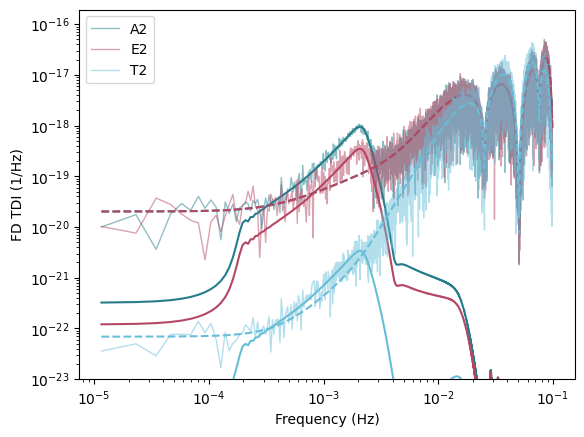

In [11]:
color_dict = dict(A2=GREEN1, E2=RED, T2=BLUE)
for ich, nch in enumerate(channel_names_opt):
    plt.loglog(data_frequency, np.abs(data_channels_opt_fd[ich]), label=nch, linewidth=1, color=color_dict[nch], alpha=0.5)
    plt.loglog(data_frequency, np.abs(model_channels_fd[ich]), color=color_dict[nch])
    plt.loglog(data_frequency, np.sqrt(data_psd_opt[ich] * Tobs / 2.), linestyle="--", color=color_dict[nch])
plt.xlabel("Frequency (Hz)")
plt.ylabel("FD TDI (1/Hz)")
plt.legend(loc="upper left")
plt.ylim(1e-23,)

## Likelihood 

In [12]:
def loglike(params): 
    p = ParamArr2ParamDict(params)
    tmp_channels_fd = signal_generator_fd(p) # (3, Nf)
    return -2.  / Tobs * np.sum(np.abs(data_channels_opt_fd - tmp_channels_fd) ** 2 / data_psd_opt)

## MCMC 

In [13]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

from corner import corner

In [14]:
labels = [r"${\rm lg}\mathcal{M}_{c,z}$", r"$q$", r"$\chi_{z,1}$", r"$\chi_{z,2}$", r"$t_c$", r"$\varphi_c$", r"${\rm lg} D_L$", r"$\cos \iota$", r"$\lambda$", r"$\sin \beta$", r"$\psi$"]

truths = ParamDict2ParamArr(mbhb_parameters)

truths

[6.509157958490574,
 0.7781530057111898,
 -0.438239,
 -0.119288,
 350.3521983769429,
 0.03221696402698365,
 5.312031251909109,
 0.011101818546490982,
 5.232529948201249,
 -0.7193737606463153,
 1.106416486745206]

In [15]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 100 # number of random walkers, limited by the vRAM of my 4080S, use fewer to speed up and more (e.g. 400) to get more smooth posterior 
ntemps = 4 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # emcee move 

stop = None 

# set priors 

# # (1) a broad prior 
# lim_lgMc = [5.5, 6.5]
# lim_q = [0.1, 0.999]
# lim_chiz1 = [-0.99, 0.99]
# lim_chiz2 = [-0.99, 0.99]
# lim_tc = [fiducial_parameters["coalescence_time"] - 500/DAY, fiducial_parameters["coalescence_time"] + 500/DAY] # assume a preliminary search step to locate the merger within 1000s
# lim_phic = [0, TWOPI]
# lim_lgD = [3.5, 5.5]
# lim_cosinc = [-1, 1]
# lim_lam = [0, TWOPI]
# lim_sinbeta = [-1, 1]
# lim_psi = [0, PI]

# (2) a narrow prior 
lim_lgMc = [truths[0] - 1e-2, truths[0] + 1e-2]
lim_q = [max(0., truths[1] - 1e-1), min(1., truths[1] + 1e-1)]
lim_chiz1 = [max(-0.99, truths[2] - 5e-1), min(0.99, truths[2] + 5e-1)]
lim_chiz2 = [max(-0.99, truths[3] - 5e-1), min(0.99, truths[3] + 5e-1)]
lim_tc = [truths[4] - 1000/DAY, truths[4] + 1000/DAY] # assume a preliminary search step to locate the merger within 1000s
lim_phic = [0, TWOPI]
lim_lgD = [4.5, 5.5]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

# set starting range 
start_lims = np.array(truths)[:, np.newaxis] + np.array([-1e-3, 1e-3])
start_priors_in = {i: uniform_dist(start_lims[i][0], start_lims[i][1]) for i in range(ndim)}
start_priors = ProbDistContainer(start_priors_in)
start_priors.use_cupy = False

lims, start_lims

(array([[ 6.49915796e+00,  6.51915796e+00],
        [ 6.78153006e-01,  8.78153006e-01],
        [-9.38239000e-01,  6.17610000e-02],
        [-6.19288000e-01,  3.80712000e-01],
        [ 3.50340624e+02,  3.50363772e+02],
        [ 0.00000000e+00,  6.28318531e+00],
        [ 4.50000000e+00,  5.50000000e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  6.28318531e+00],
        [-1.00000000e+00,  1.00000000e+00],
        [ 0.00000000e+00,  3.14159265e+00]]),
 array([[ 6.50815796e+00,  6.51015796e+00],
        [ 7.77153006e-01,  7.79153006e-01],
        [-4.39239000e-01, -4.37239000e-01],
        [-1.20288000e-01, -1.18288000e-01],
        [ 3.50351198e+02,  3.50353198e+02],
        [ 3.12169640e-02,  3.32169640e-02],
        [ 5.31103125e+00,  5.31303125e+00],
        [ 1.01018185e-02,  1.21018185e-02],
        [ 5.23152995e+00,  5.23352995e+00],
        [-7.20373761e-01, -7.18373761e-01],
        [ 1.10541649e+00,  1.10741649e+00]]))

In [16]:
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    loglike, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=False,
    pool=pool, 
)

In [ ]:
# randomize starting positions throughout prior
coords = start_priors.rvs(size=(ntemps, nwalkers,))

thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by) # should be more than enough 

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

  0%|          | 58/100000 [03:07<81:59:06,  2.95s/it] 

In [ ]:
thin = 10
burnin = 0
len_chain = len(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, 0, :, 0])

plt.figure()
fig, ax = plt.subplots(ndim, 1)
fig.set_size_inches(10, 3*ndim)
for i in range(ndim):     
    for walk in range(20): # plot 20 walkers 
        ax[i].plot(ensemble.get_chain(thin=thin, discard=burnin)['model_0'][:, 0, walk, 0, i])
        ax[i].hlines(truths[i], 0, len_chain, color='k', linestyle='-.', linewidth=0.8)
    ax[i].set_ylabel(labels[i])
# plt.savefig("MCMC_trajectory_full.jpg", dpi=360)

In [ ]:
burnin=200 # currently the number of burn-in steps is only set by monitoring the walkers. It should be more automatic for practical uses.
thin = 10

samp = ensemble.get_chain(discard=burnin, thin=thin)['model_0'][:, 0, :, :, :].reshape(-1, ndim)
print("sample shape:", samp.shape)

plt.figure()
corner(
    samp, bins=50, color=BLUE, 
    labels=labels, label_kwargs={'fontsize': 14}, 
    # range=lims,
    truths=truths, truth_color=RED, 
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, title_kwargs={'fontsize':14},
    levels = (1. - np.exp(-1.**2/2), 1. - np.exp(-2.**2/2), 1. - np.exp(-3.**2/2)),
    smooth=0.9, # default for bilby: smooth = 0.9, bins = 50 
    plot_density=True, # whether to show the density of samples with colors 
    plot_datapoints=False, # whether to plot individual data points 
    fill_contours=True, # whether to fill the corners 
    );
# plt.savefig("MCMC_corner_full.jpg", dpi=360)
# np.save("chain_full.npy", samp)